In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import random
import math
import tqdm
import os
from typing import *

random.seed(192837)
torch.manual_seed(192838)

In [2]:
# CHARS = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890@#$%&БГДЖИПФЦШЪЫЬЭЮЯΔΘΛΞΣΨΩ'
CHARS = '0123456789'
N_CLASSES = len(CHARS)
CHAR_TO_CLS = {CHARS[i]: i for i in range(N_CLASSES)}

TRAIN_TEST_SPLIT = 0.9
BATCH_SIZE = 32

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1) # 14
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=2) # 8
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1) # 4
        self.conv4 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 2

        self.head1 = nn.Linear(32 * 4, 32)
        self.head2 = nn.Linear(32, 32)
        self.head3 = nn.Linear(32, N_CLASSES)
    
    def forward(self, x):
        if len(x.shape) == 3:  # unbatched input
            x = x.unsqueeze(0)
        B = x.shape[0]

        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x))).reshape((B, -1))

        x = self.relu(self.head1(x))
        x = self.relu(self.head2(x))
        x = self.head3(x)

        return x.squeeze(0)

In [4]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [5]:
dataset_train = datasets.MNIST(root='mnist', train=True, download=True, transform=transform)
dataset_test = datasets.MNIST(root='mnist', train=False, download=True, transform=transform)

loader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9.91M/9.91M [01:36<00:00, 103kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 138kB/s]
100%|██████████| 1.65M/1.65M [00:09<00:00, 169kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 566kB/s]


In [6]:
def train_epoch(model: nn.Module, optimizer: optim.Optimizer, loader: DataLoader):
    model.train()
    
    loss_sum = 0
    accu_sum = 0
    n_batches = len(loader)

    for x, y in tqdm.tqdm(loader, 'train'):
        y_hat = model.forward(x)

        loss = F.cross_entropy(y_hat, y)
        loss_sum += loss.detach().clone()

        with torch.no_grad():
            accu_sum += torch.sum(y_hat.argmax(dim=-1) == y) / x.shape[0]

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return loss_sum / n_batches, accu_sum / n_batches

def test_epoch(model: nn.Module, loader: DataLoader):
    model.eval()
    
    with torch.no_grad():
        loss_sum = 0
        accu_sum = 0
        n_batches = len(loader)

        for x, y in tqdm.tqdm(loader, ' test'):
            y_hat = model.forward(x)

            loss = F.cross_entropy(y_hat, y)
            loss_sum += loss
            accu_sum += torch.sum(y_hat.argmax(dim=-1) == y) / x.shape[0]
        
        return loss_sum / n_batches, accu_sum / n_batches

In [7]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
N_EPOCHS = 10

In [8]:
for epoch_i in range(N_EPOCHS):
    print(f'=== epoch {epoch_i} ===')

    train_loss, train_accu = train_epoch(model, optimizer, loader_train)
    test_loss, test_accu = test_epoch(model, loader_test)

    print('train loss:', train_loss.item())
    print(' test loss:', test_loss.item())
    print('train accu:', train_accu.item())
    print(' test accu:', test_accu.item())

=== epoch 0 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 129.82it/s]


train loss: 0.4667964577674866
 test loss: 0.14405743777751923
train accu: 0.84170001745224
 test accu: 0.9532747864723206
=== epoch 1 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 131.79it/s]


train loss: 0.13769815862178802
 test loss: 0.09398181736469269
train accu: 0.9570333361625671
 test accu: 0.9699480533599854
=== epoch 2 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 119.06it/s]


train loss: 0.0994635820388794
 test loss: 0.07223112881183624
train accu: 0.9688833355903625
 test accu: 0.9756389856338501
=== epoch 3 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 110.00it/s]


train loss: 0.08110949397087097
 test loss: 0.06481283158063889
train accu: 0.9744166731834412
 test accu: 0.9810303449630737
=== epoch 4 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 117.06it/s]


train loss: 0.06947487592697144
 test loss: 0.05163741111755371
train accu: 0.9782333374023438
 test accu: 0.9833266735076904
=== epoch 5 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 126.41it/s]


train loss: 0.05939078330993652
 test loss: 0.0466652475297451
train accu: 0.9810333251953125
 test accu: 0.9863218665122986
=== epoch 6 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 119.86it/s]


train loss: 0.0527217760682106
 test loss: 0.056206658482551575
train accu: 0.9831833243370056
 test accu: 0.9834265112876892
=== epoch 7 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 130.14it/s]


train loss: 0.0489988699555397
 test loss: 0.05262840539216995
train accu: 0.9844833612442017
 test accu: 0.9834265112876892
=== epoch 8 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 125.43it/s]


train loss: 0.044746577739715576
 test loss: 0.043482791632413864
train accu: 0.9858999848365784
 test accu: 0.9866213798522949
=== epoch 9 ===


 test: 100%|██████████| 313/313 [00:02<00:00, 126.23it/s]

train loss: 0.04196130111813545
 test loss: 0.043378401547670364
train accu: 0.986549973487854
 test accu: 0.9863218665122986


['7', '2', '1', '0', '4', '1', '4', '9', '5', '9']
7 tensor(1.0000, grad_fn=<MaxBackward1>)
2 tensor(1.0000, grad_fn=<MaxBackward1>)
1 tensor(0.9997, grad_fn=<MaxBackward1>)
0 tensor(1.0000, grad_fn=<MaxBackward1>)
4 tensor(0.9999, grad_fn=<MaxBackward1>)
1 tensor(0.9999, grad_fn=<MaxBackward1>)
4 tensor(0.9989, grad_fn=<MaxBackward1>)
9 tensor(0.9906, grad_fn=<MaxBackward1>)
5 tensor(0.9900, grad_fn=<MaxBackward1>)
9 tensor(0.9999, grad_fn=<MaxBackward1>)


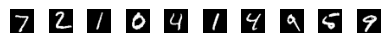

In [9]:
examples, examples_y = next(iter(loader_test))
print([CHARS[examples_y[i]] for i in range(10)])

pred = torch.softmax(model.forward(examples), dim=-1)
for i in range(10):
    print(CHARS[pred[i].argmax()], pred[i].max())

fig, axes = plt.subplots(1, 10, figsize=(4, 10 * 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(examples[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
class AntiCNN():
    def __init__(self,
               inner_net: nn.Module,
               desired_c: int,
               lr: float=1e-2,
               right_c_coef: float=1.0,
               wrong_c_coef: float=1.0):
        super().__init__()

        self.input_shape = (1, 32, 32)
        self.input = nn.Parameter(
            data=torch.rand(size=self.input_shape),
            requires_grad=True
        )
        self.inner_net = inner_net
        self.grad_eraser = torch.optim.SGD(self.inner_net.parameters())
        self.anti_optimizer = torch.optim.Adam((self.input,), lr=lr)

        self.desired_c = desired_c
        self.right_c_coef = right_c_coef
        self.wrong_c_coef = wrong_c_coef

        self.input_min = 0.0
        self.input_max = 1.0
        self.softmax = lambda t: torch.softmax(t, dim=-1)

    def test(self):
        with torch.no_grad():
            return self.inner_net.forward(self.input)
    
    def zero_grad(self):
        self.grad_eraser.zero_grad()
        self.anti_optimizer.zero_grad()

    def crop(self):
        self.input.data.copy_(torch.clamp(self.input.detach().clone(), self.input_min, self.input_max))
    
    def step(self):
        prev_input = self.input.detach().clone()

        output = self.inner_net.forward(self.input)
        output_soft = self.softmax(output)
        
        loss = output_soft[torch.arange(0, N_CLASSES) != self.desired_c].sum() * self.wrong_c_coef + \
               output_soft[self.desired_c] * -self.right_c_coef
        loss.backward()
        self.anti_optimizer.step()
        self.zero_grad()

        self.crop()

        return prev_input, output.detach().clone(), loss.detach().clone()

-=-=- step 0 -=-=-
des crctr: 0 (0)


100%|██████████| 3000/3000 [00:08<00:00, 370.29it/s]

fin output: tensor([9.9978e-01, 2.9227e-05, 2.9320e-05, 9.2699e-06, 6.2025e-08, 1.0702e-06,
        8.2470e-05, 3.7874e-06, 2.9521e-05, 3.7106e-05])
fin loss: -0.9995562434196472
fin input:


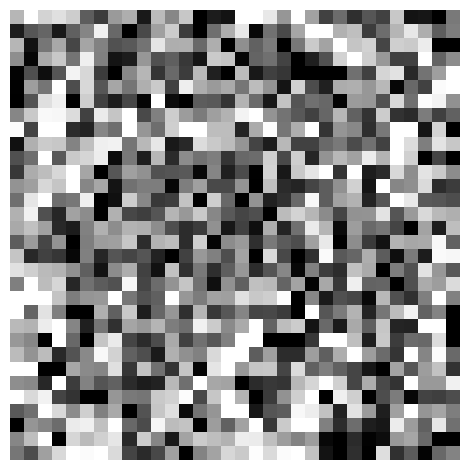

-=-=- step 1 -=-=-
des crctr: 1 (1)


100%|██████████| 3000/3000 [00:08<00:00, 367.68it/s]

fin output: tensor([6.0917e-07, 9.9965e-01, 7.7209e-06, 3.0352e-06, 3.1610e-05, 6.8588e-07,
        2.5335e-06, 1.2801e-04, 1.5788e-04, 1.5887e-05])
fin loss: -0.9993040561676025
fin input:


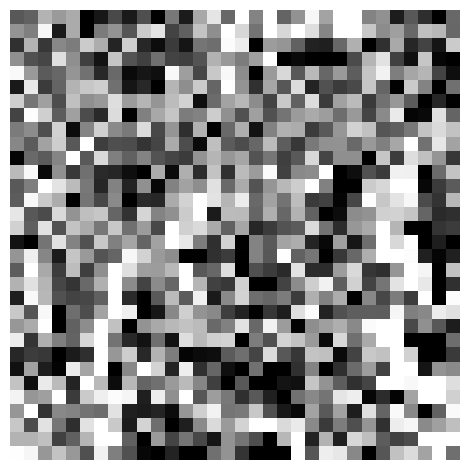

-=-=- step 2 -=-=-
des crctr: 2 (2)


100%|██████████| 3000/3000 [00:07<00:00, 377.94it/s]

fin output: tensor([7.3559e-06, 2.4654e-04, 9.9961e-01, 9.6698e-05, 5.5977e-06, 1.6499e-08,
        6.1915e-07, 1.8991e-05, 9.9871e-06, 1.0844e-07])
fin loss: -0.9992281198501587
fin input:


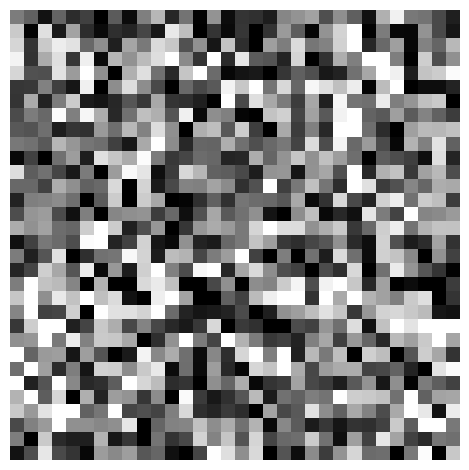

-=-=- step 3 -=-=-
des crctr: 3 (3)


100%|██████████| 3000/3000 [00:07<00:00, 377.29it/s]


fin output: tensor([9.6347e-06, 8.1121e-06, 6.5194e-06, 9.9983e-01, 3.2114e-09, 8.9300e-05,
        1.7085e-09, 1.5962e-07, 4.5762e-05, 1.1809e-05])
fin loss: -0.999657392501831
fin input:


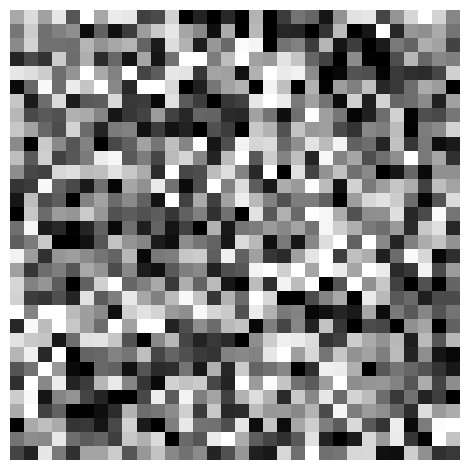

-=-=- step 4 -=-=-
des crctr: 4 (4)


100%|██████████| 3000/3000 [00:08<00:00, 374.99it/s]


fin output: tensor([7.5980e-10, 7.5100e-06, 9.7294e-06, 1.9203e-07, 9.9990e-01, 8.8752e-07,
        7.5046e-06, 1.9809e-05, 3.2295e-05, 2.1392e-05])
fin loss: -0.9998012781143188
fin input:


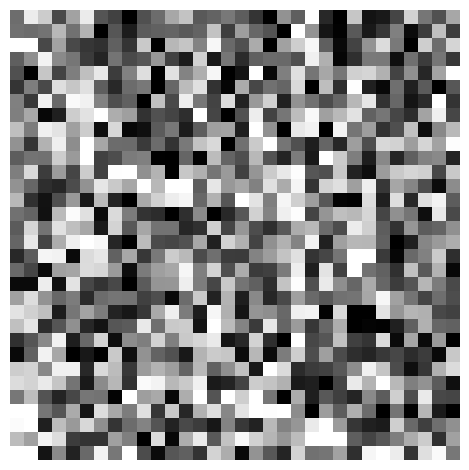

-=-=- step 5 -=-=-
des crctr: 5 (5)


100%|██████████| 3000/3000 [00:08<00:00, 335.10it/s]

fin output: tensor([6.6869e-07, 2.4581e-06, 7.4922e-08, 6.3463e-05, 2.8471e-07, 9.9988e-01,
        1.5498e-05, 5.0513e-06, 1.7886e-05, 1.0101e-05])
fin loss: -0.9997689723968506
fin input:


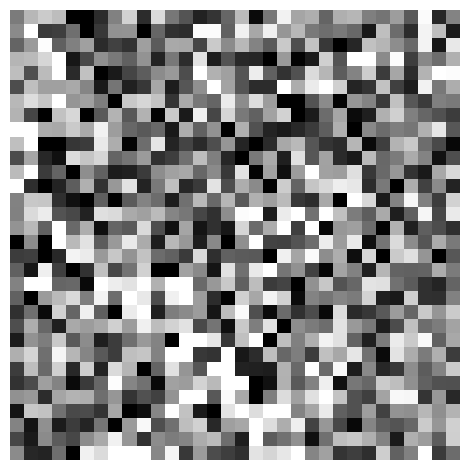

-=-=- step 6 -=-=-
des crctr: 6 (6)


100%|██████████| 3000/3000 [00:08<00:00, 338.97it/s]


fin output: tensor([2.7789e-05, 2.3621e-07, 4.5595e-07, 6.8962e-09, 7.3144e-06, 6.3180e-05,
        9.9984e-01, 1.3383e-10, 6.2143e-05, 1.3238e-09])
fin loss: -0.9996777176856995
fin input:


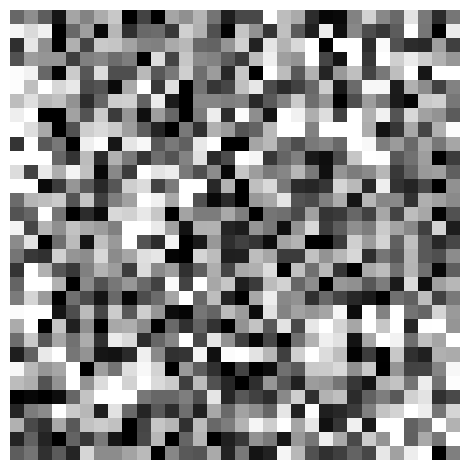

-=-=- step 7 -=-=-
des crctr: 7 (7)


100%|██████████| 3000/3000 [00:08<00:00, 342.63it/s]


fin output: tensor([2.5049e-08, 3.9565e-05, 1.7182e-05, 3.7746e-05, 3.2462e-06, 4.8677e-05,
        2.7993e-10, 9.9979e-01, 7.8054e-06, 5.2788e-05])
fin loss: -0.9995859861373901
fin input:


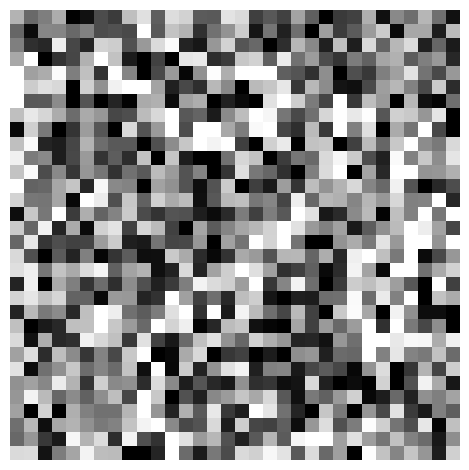

-=-=- step 8 -=-=-
des crctr: 8 (8)


100%|██████████| 3000/3000 [00:08<00:00, 362.46it/s]


fin output: tensor([6.9754e-08, 7.1115e-07, 7.1717e-06, 5.5199e-07, 1.1846e-08, 5.5235e-07,
        1.5152e-05, 9.1498e-09, 9.9998e-01, 5.7968e-08])
fin loss: -0.9999514222145081
fin input:


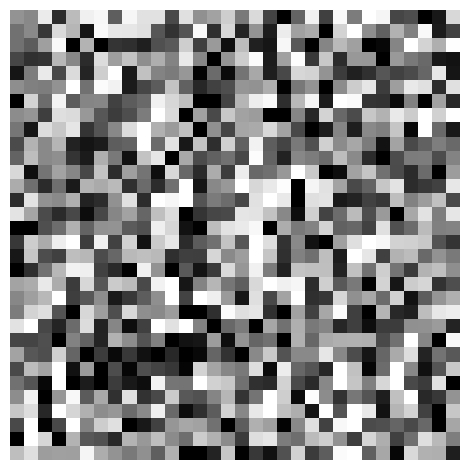

-=-=- step 9 -=-=-
des crctr: 9 (9)


100%|██████████| 3000/3000 [00:08<00:00, 347.10it/s]


fin output: tensor([4.2457e-07, 8.4812e-07, 9.7492e-08, 4.9631e-05, 2.1003e-04, 2.3319e-06,
        4.7491e-10, 1.0445e-04, 9.2094e-06, 9.9962e-01])
fin loss: -0.9992459416389465
fin input:


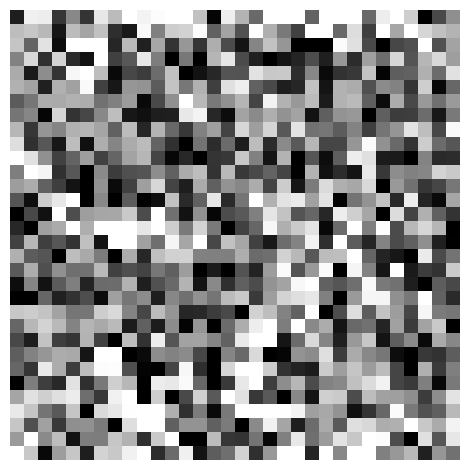

In [11]:
ANTI_NET_STEPS = 3000
TEST_EXAMPLES = 10
TEST_TRIES = 10

for i in range(10):
    desired_c = i

    print(f'-=-=- step {i} -=-=-')
    print(f'des crctr:', CHARS[desired_c], f'({desired_c})')

    fin_loss = float('+inf')
    fin_inp, fin_outp = None, None

    for try_i in range(TEST_TRIES):
        anti_net = AntiCNN(model, desired_c, lr=1e-3)
        for step_i in tqdm.tqdm(range(ANTI_NET_STEPS)):
            inp, outp, loss = anti_net.step()
        
        if loss.item() < fin_loss:
            fin_loss = loss.item()
            fin_inp = inp
            fin_outp = outp

    print(f'fin output:', anti_net.softmax(fin_outp))
    print(f'fin loss:', fin_loss)
    print(f'fin input:')

    plt.imshow(fin_inp.squeeze(), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()